In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/





Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1aoCshV-2PftuFYPQbjKUxee7qH8ekro_/CAIS++ Mini Project + Final Project/xview2


In [ ]:
import os

folder_to_list = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train'
contents = os.listdir(folder_to_list)
print(f"Contents of {folder_to_list}:")
for item in contents:
    print(item)

Contents of /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train:
images
targets
labels
processed
processed_data


In [ ]:
import os
OUT_DIR = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed'
contents_processed = os.listdir(OUT_DIR)
print(f"Contents of {OUT_DIR}:")
for item in contents_processed:
    print(item)

Contents of /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed:
pre
post
masks
1
2
3
4
5


In [ ]:
import os

def count_png_files(folder_path):
    png_count = 0
    if os.path.exists(folder_path):
        for f in os.listdir(folder_path):
            if f.lower().endswith('.png'):
                png_count += 1
    return png_count

pre_folder = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/pre'
post_folder = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/post'

pre_png_count = count_png_files(pre_folder)
post_png_count = count_png_files(post_folder)

print(f"Number of PNG files in {pre_folder}: {pre_png_count}")
print(f"Number of PNG files in {post_folder}: {post_png_count}")

Number of PNG files in /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/pre: 0
Number of PNG files in /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/post: 0


In [ ]:
# import os
# import shutil

# pre_folder = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/pre'
# post_folder = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/post'
# destination_folder = '/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/images'

# # Ensure the destination folder exists
# os.makedirs(destination_folder, exist_ok=True)

# def move_png_files(source_folder, dest_folder):
#     if not os.path.exists(source_folder):
#         print(f"Source folder does not exist: {source_folder}")
#         return

#     print(f"Moving files from {source_folder} to {dest_folder}...")
#     for filename in os.listdir(source_folder):
#         if filename.lower().endswith('.png'):
#             src_path = os.path.join(source_folder, filename)
#             dest_path = os.path.join(dest_folder, filename)
#             try:
#                 shutil.move(src_path, dest_path)
#                 # print(f"Moved: {filename}")
#             except Exception as e:
#                 print(f"Error moving {filename}: {e}")

# move_png_files(pre_folder, destination_folder)
# move_png_files(post_folder, destination_folder)

# print("All specified PNG files have been moved.")

Moving files from /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/pre to /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/images...
Moving files from /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed/post to /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/images...
All specified PNG files have been moved.


In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
!pip install shapely opencv-python-headless

In [ ]:
import os

folder_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/images"

png_count = sum(
    1 for f in os.listdir(folder_path)
    if f.lower().endswith(".png")
)

print("Number of PNG files:", png_count)


Number of PNG files: 5598


In [ ]:
import os

folder_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/labels"

json_count = sum(
    1 for f in os.listdir(folder_path)
    if f.lower().endswith(".json")
)

print("Number of JSON files:", json_count)

Number of JSON files: 5598


confirmed: number of json files and and png files match

next two cells analyse class balance

In [ ]:
import os
import json
from collections import Counter
from tqdm import tqdm

# --- CONFIGURATION ---
# Adjust path to where your 'train/labels' folder is mounted
DRIVE_ROOT = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2"
LABELS_DIR = os.path.join(DRIVE_ROOT, "train", "labels")

# Standard xView2 Damage Mapping
DAMAGE_MAP = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

# Initialize Counters
building_counts = Counter()  # Counts total buildings per class
image_counts = Counter()     # Counts images by their "max damage" level

print(f"Scanning labels in: {LABELS_DIR}...")

# Get list of all JSON files
all_files = [f for f in os.listdir(LABELS_DIR) if f.endswith(".json")]

# Filter for ONLY post-disaster files
post_files = [f for f in all_files if "post_disaster" in f]

print(f"Found {len(post_files)} post-disaster label files.")

for fname in tqdm(post_files):
    path = os.path.join(LABELS_DIR, fname)

    try:
        with open(path) as f:
            data = json.load(f)
    except Exception as e:
        print(f"Error reading {fname}: {e}")
        continue

    # Get building features (using 'xy' coordinates is safest for pixel masks)
    # If you want ALL metadata buildings, use 'lng_lat', but 'xy' is better for training alignment.
    features = data.get("features", {}).get("xy", [])

    # Case: No buildings in this image
    if not features:
        image_counts[0] += 1  # Class 0 = Background / No Buildings
        continue

    max_damage_in_image = 0

    for feat in features:
        props = feat.get("properties", {})
        subtype = props.get("subtype", "no-damage") # Default if key missing

        class_id = DAMAGE_MAP.get(subtype, 1) # Default to 1 if string unknown

        # 1. Count specific building instance
        building_counts[class_id] += 1

        # Track max damage for this image
        if class_id > max_damage_in_image:
            max_damage_in_image = class_id

    # 2. Count image by its most severe damage
    image_counts[max_damage_in_image] += 1

print("\n" + "="*40)
print("   BUILDING-LEVEL STATISTICS")
print("   (Total number of buildings per class)")
print("="*40)
for class_id in sorted(DAMAGE_MAP.values()):
    name = [k for k, v in DAMAGE_MAP.items() if v == class_id][0]
    count = building_counts[class_id]
    print(f"Class {class_id} ({name}): {count}")

print("\n" + "="*40)
print("   IMAGE-LEVEL STATISTICS")
print("   (Images categorized by their max damage)")
print("="*40)
# Include Class 0 (Empty Images)
all_classes = [0] + sorted(DAMAGE_MAP.values())
for class_id in all_classes:
    if class_id == 0:
        name = "Background / No Building"
    else:
        name = [k for k, v in DAMAGE_MAP.items() if v == class_id][0]

    count = image_counts[class_id]
    print(f"Class {class_id} ({name}): {count}")

Scanning labels in: /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/labels...
Found 2799 post-disaster label files.


100%|██████████| 2799/2799 [01:38<00:00, 28.34it/s] 


   BUILDING-LEVEL STATISTICS
   (Total number of buildings per class)
Class 1 (no-damage): 117426
Class 2 (minor-damage): 14980
Class 3 (major-damage): 14161
Class 4 (destroyed): 13227
Class 5 (un-classified): 2993

   IMAGE-LEVEL STATISTICS
   (Images categorized by their max damage)
Class 0 (Background / No Building): 516
Class 1 (no-damage): 558
Class 2 (minor-damage): 147
Class 3 (major-damage): 323
Class 4 (destroyed): 572
Class 5 (un-classified): 683


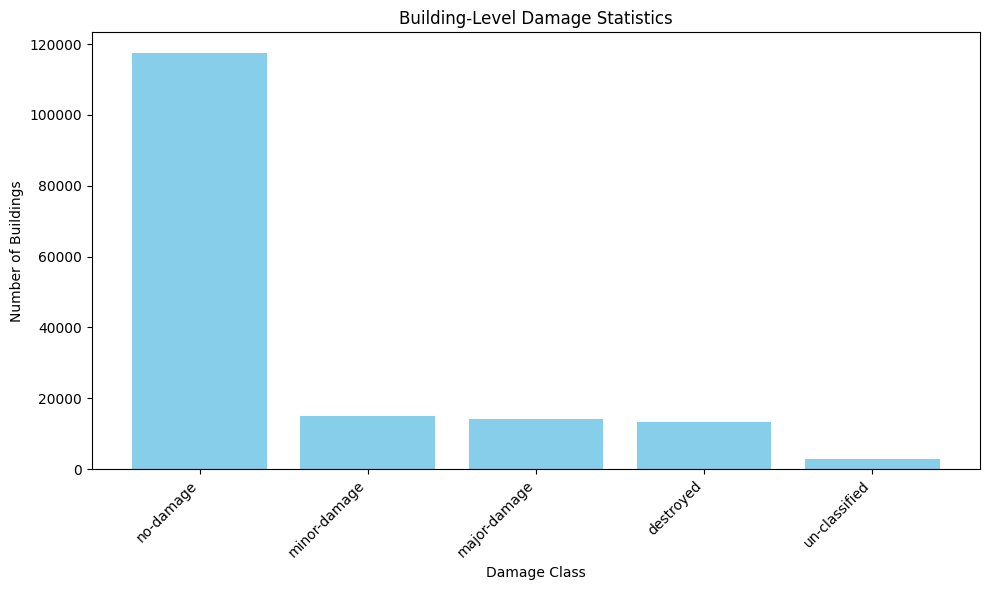

In [ ]:
import matplotlib.pyplot as plt

# building_counts and DAMAGE_MAP are already available in the kernel state

# Prepare data for plotting
labels = []
counts = []
# Map class IDs to their names for better labels on the plot
id_to_name = {v: k for k, v in DAMAGE_MAP.items()}

for class_id in sorted(building_counts.keys()):
    labels.append(id_to_name.get(class_id, f"Class {class_id}")) # Fallback for unexpected IDs
    counts.append(building_counts[class_id])

# Create the histogram (bar chart)
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Damage Class')
plt.ylabel('Number of Buildings')
plt.title('Building-Level Damage Statistics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The visualization above should allow us to feel confident that we've counted the observations more or less correctly as the distribution for the damage classes resembles IBM's histogram. Class imbalance so we need to do some data augmentation

do not need to run any of the cells below. they were already run to upload the processed data to the drive as a zip

The following code is to unzip the folder storing the processed images and masks so that you don't have to process the raw data every time

In [ ]:
# --- UNZIP LOGIC (for future use) ---
# This demonstrates how to unzip the file back to the local environment
# You would run this part in a new session to load the data
zip_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed_data/processed_dataset_binary.zip"
extract_path = "/content/processed_dataset_binary"

# Only unzip if the destination doesn't already exist (to avoid overwriting/errors in this session)
if not os.path.exists(extract_path):
    print(f"Unzipping {zip_path} to {extract_path}...")
    shutil.unpack_archive(zip_path, extract_path)
    print("Unzip complete!")
else:
    print(f"Directory {extract_path} already exists. Skipping unzip.")

# following cell is to process data for the binary building/no building model

In [ ]:
import os
import json
import cv2
import numpy as np
import shapely.wkt
import shutil
from glob import glob
from tqdm import tqdm

# --- CONFIGURATION ---
DRIVE_ROOT = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2"
INPUT_DIR = os.path.join(DRIVE_ROOT, "train")
IMAGES_DIR = os.path.join(INPUT_DIR, "images")
LABELS_DIR = os.path.join(INPUT_DIR, "labels")

# Local Output (Fast I/O)
OUTPUT_DIR = "/content/processed_dataset_binary"

# Tiling Settings
TILE_SIZE = 512
STRIDE = 256

def create_binary_mask(json_path, img_shape=(1024, 1024)):
    """
    Parses JSON and returns a BINARY mask.
    0 = Background
    1 = Building (Any status)
    """
    mask = np.zeros(img_shape, dtype=np.uint8)

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return mask

    if 'features' not in data or 'xy' not in data['features']:
        return mask

    for feature in data['features']['xy']:
        wkt_str = feature.get('wkt')
        if not wkt_str: continue

        polygon = shapely.wkt.loads(wkt_str)

        if not polygon.is_empty:
            x, y = polygon.exterior.coords.xy
            points = np.array([list(zip(x, y))], dtype=np.int32)

            # FILL WITH 1 (Building) regardless of damage type
            cv2.fillPoly(mask, points, color=1)

    return mask

def tile_and_save(image, mask, filename_base, output_dir, tile_size=512, stride=256):
    h, w, _ = image.shape

    out_img_dir = os.path.join(output_dir, "images")
    out_mask_dir = os.path.join(output_dir, "masks")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    tile_idx = 0

    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            img_tile = image[y:y+tile_size, x:x+tile_size]
            mask_tile = mask[y:y+tile_size, x:x+tile_size]

            # Save Chip
            save_name = f"{filename_base}_tile_{tile_idx}.png"
            cv2.imwrite(os.path.join(out_img_dir, save_name), img_tile)
            cv2.imwrite(os.path.join(out_mask_dir, save_name), mask_tile)

            tile_idx += 1

# --- MAIN EXECUTION ---
print("1. Listing ALL label files (Pre and Post)...")
# We grab ALL json files because both pre/post are valid for building detection
label_files = glob(os.path.join(LABELS_DIR, "*.json"))
print(f"Found {len(label_files)} label files.")

print(f"2. Starting Binary Processing...")

for json_path in tqdm(label_files):
    filename = os.path.basename(json_path)
    file_id = os.path.splitext(filename)[0]

    # Check for Image
    img_path = os.path.join(IMAGES_DIR, file_id + ".png")
    if not os.path.exists(img_path):
        continue

    # Read Image
    image = cv2.imread(img_path)
    if image is None: continue

    # Create Binary Mask (0 or 1)
    mask = create_binary_mask(json_path, image.shape[:2])

    # Tile and Save
    tile_and_save(image, mask, file_id, OUTPUT_DIR, TILE_SIZE, STRIDE)

print("Processing complete!")

# --- SAVE TO DRIVE ---
print("Zipping and saving to Drive...")
# Create the zip locally first
shutil.make_archive("/content/processed_dataset_binary", 'zip', OUTPUT_DIR)

# Define Destination: xview2/train/processed_data
# CHANGED: Path updated to 'processed_data' inside 'train'
drive_dest_dir = os.path.join(DRIVE_ROOT, "train", "processed_data")
os.makedirs(drive_dest_dir, exist_ok=True)

destination = os.path.join(drive_dest_dir, "processed_dataset_binary.zip")

print(f"Copying to {destination}...")
shutil.copy("/content/processed_dataset_binary.zip", destination)
print(f"Success! Binary dataset saved.")

1. Listing ALL label files (Pre and Post)...
Found 5598 label files.
2. Starting Binary Processing...


100%|██████████| 5598/5598 [1:11:22<00:00,  1.31it/s]


Processing complete!
Zipping and saving to Drive...
Copying to /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed_data/processed_dataset_binary.zip...
Success! Binary dataset saved.


# cell below is to process data to use for damage assessment model training

In [ ]:
import os
import json
import cv2
import numpy as np
import shapely.wkt
from glob import glob
from tqdm import tqdm
import shutil

# --- CONFIGURATION ---
DRIVE_ROOT = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2"
INPUT_DIR = os.path.join(DRIVE_ROOT, "train")
IMAGES_DIR = os.path.join(INPUT_DIR, "images")
LABELS_DIR = os.path.join(INPUT_DIR, "labels")

# Output Folder
OUTPUT_DIR = "/content/processed_dataset_damage"

TILE_SIZE = 512
STRIDE = 256

DAMAGE_MAP = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

def create_mask_from_json(json_path, img_shape=(1024, 1024)):
    """Creates 2D semantic mask from Post-Disaster JSON."""
    mask = np.zeros(img_shape, dtype=np.uint8)
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return mask

    if 'features' not in data or 'xy' not in data['features']:
        return mask

    for feature in data['features']['xy']:
        wkt_str = feature.get('wkt')
        subtype = feature['properties'].get('subtype', 'no-damage')

        if not wkt_str: continue

        damage_id = DAMAGE_MAP.get(subtype, 1)
        polygon = shapely.wkt.loads(wkt_str)

        if not polygon.is_empty:
            x, y = polygon.exterior.coords.xy
            points = np.array([list(zip(x, y))], dtype=np.int32)
            cv2.fillPoly(mask, points, color=damage_id)

    return mask

def tile_and_save_triplet(img_pre, img_post, mask, name_pre, name_post, output_dir):
    """
    Tiles Pre, Post, and Mask simultaneously.
    Saves them with correct filenames to avoid confusion.
    """
    h, w, _ = img_post.shape

    # Create 3 output directories
    dir_pre = os.path.join(output_dir, "images_pre")
    dir_post = os.path.join(output_dir, "images_post")
    dir_mask = os.path.join(output_dir, "masks")

    os.makedirs(dir_pre, exist_ok=True)
    os.makedirs(dir_post, exist_ok=True)
    os.makedirs(dir_mask, exist_ok=True)

    tile_idx = 0

    for y in range(0, h - TILE_SIZE + 1, STRIDE):
        for x in range(0, w - TILE_SIZE + 1, STRIDE):
            # Extract Chips
            tile_pre = img_pre[y:y+TILE_SIZE, x:x+TILE_SIZE]
            tile_post = img_post[y:y+TILE_SIZE, x:x+TILE_SIZE]
            tile_mask = mask[y:y+TILE_SIZE, x:x+TILE_SIZE]

            # Construct Filenames
            # Pre tiles get PRE name
            save_name_pre = f"{name_pre}_tile_{tile_idx}.png"
            # Post tiles get POST name
            save_name_post = f"{name_post}_tile_{tile_idx}.png"
            # Masks align with Post name
            save_name_mask = f"{name_post}_tile_{tile_idx}.png"

            cv2.imwrite(os.path.join(dir_pre, save_name_pre), tile_pre)
            cv2.imwrite(os.path.join(dir_post, save_name_post), tile_post)
            cv2.imwrite(os.path.join(dir_mask, save_name_mask), tile_mask)

            tile_idx += 1

# --- MAIN EXECUTION ---
print("Starting Siamese Pipeline...")

# Only look for Post-Disaster JSONs (they contain the damage labels)
all_labels = glob(os.path.join(LABELS_DIR, "*_post_disaster.json"))
print(f"Found {len(all_labels)} post-disaster scenes.")

for json_path in tqdm(all_labels):
    filename = os.path.basename(json_path)
    file_id_post = os.path.splitext(filename)[0] # e.g. 'hurricane_001_post_disaster'

    # Derive filenames
    # Post image has same name as Post JSON (but .png)
    post_img_path = os.path.join(IMAGES_DIR, file_id_post + ".png")

    # Pre image replaces 'post_disaster' with 'pre_disaster'
    file_id_pre = file_id_post.replace("_post_disaster", "_pre_disaster")
    pre_img_path = os.path.join(IMAGES_DIR, file_id_pre + ".png")

    # Check existence of BOTH images
    if not os.path.exists(post_img_path) or not os.path.exists(pre_img_path):
        continue

    # Read Images
    img_post = cv2.imread(post_img_path)
    img_pre = cv2.imread(pre_img_path)

    if img_post is None or img_pre is None: continue

    # Generate Mask (Using Post-Disaster JSON)
    mask = create_mask_from_json(json_path, img_post.shape[:2])

    # Tile all three together
    tile_and_save_triplet(img_pre, img_post, mask,
                          name_pre=file_id_pre,
                          name_post=file_id_post,
                          output_dir=OUTPUT_DIR)

print("Siamese Processing Complete!")

# Save to Drive
print("Zipping and saving...")
shutil.make_archive("/content/processed_dataset_damage", 'zip', OUTPUT_DIR)
drive_dest = os.path.join(DRIVE_ROOT, "train", "processed_data")
os.makedirs(drive_dest, exist_ok=True)
shutil.copy("/content/processed_dataset_damage.zip", os.path.join(drive_dest, "processed_dataset_damage.zip"))
print("Done.")

Starting Siamese Pipeline...
Found 2799 post-disaster scenes.


100%|██████████| 2799/2799 [46:39<00:00,  1.00s/it]


Siamese Processing Complete!
Zipping and saving...
Done.


# Processing test data for binary and then damage model

In [ ]:
import os

folder_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/test/images"

png_count = sum(
    1 for f in os.listdir(folder_path)
    if f.lower().endswith(".png")
)

print("Number of PNG files:", png_count)

folder_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/test/labels"

json_count = sum(
    1 for f in os.listdir(folder_path)
    if f.lower().endswith(".json")
)

print("Number of JSON files:", json_count)

Number of PNG files: 1866
Number of JSON files: 1866


following cell processing test data for binary model

In [ ]:
import os
import json
import cv2
import numpy as np
import shapely.wkt
import shutil
from glob import glob
from tqdm import tqdm

# --- CONFIGURATION FOR TEST DATA ---
DRIVE_ROOT = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2"

# Pointing to the TEST folder
INPUT_DIR = os.path.join(DRIVE_ROOT, "test")
IMAGES_DIR = os.path.join(INPUT_DIR, "images")
LABELS_DIR = os.path.join(INPUT_DIR, "labels")

# Local Output (Fast I/O)
OUTPUT_DIR = "/content/processed_binary_test"

# Destination on Google Drive
DRIVE_DEST_DIR = os.path.join(INPUT_DIR, "processed_data_test")

# Tiling Settings (Must match training settings)
TILE_SIZE = 512
STRIDE = 256

def create_binary_mask(json_path, img_shape=(1024, 1024)):
    """
    Parses JSON and returns a BINARY mask.
    0 = Background
    1 = Building (Any status)
    """
    mask = np.zeros(img_shape, dtype=np.uint8)

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return mask

    if 'features' not in data or 'xy' not in data['features']:
        return mask

    for feature in data['features']['xy']:
        wkt_str = feature.get('wkt')
        if not wkt_str: continue

        polygon = shapely.wkt.loads(wkt_str)

        if not polygon.is_empty:
            x, y = polygon.exterior.coords.xy
            points = np.array([list(zip(x, y))], dtype=np.int32)

            # FILL WITH 1 (Building)
            cv2.fillPoly(mask, points, color=1)

    return mask

def tile_and_save(image, mask, filename_base, output_dir, tile_size=512, stride=256):
    h, w, _ = image.shape

    out_img_dir = os.path.join(output_dir, "images")
    out_mask_dir = os.path.join(output_dir, "masks")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_mask_dir, exist_ok=True)

    tile_idx = 0

    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            img_tile = image[y:y+tile_size, x:x+tile_size]
            mask_tile = mask[y:y+tile_size, x:x+tile_size]

            # Save Chip
            save_name = f"{filename_base}_tile_{tile_idx}.png"
            cv2.imwrite(os.path.join(out_img_dir, save_name), img_tile)
            cv2.imwrite(os.path.join(out_mask_dir, save_name), mask_tile)

            tile_idx += 1

# --- MAIN EXECUTION ---
print("1. Listing ALL label files in TEST folder...")
# We use all JSONs (Pre + Post) to maximize test coverage for localization
label_files = glob(os.path.join(LABELS_DIR, "*.json"))
print(f"Found {len(label_files)} label files.")

print(f"2. Starting Test Data Processing...")

for json_path in tqdm(label_files):
    filename = os.path.basename(json_path)
    file_id = os.path.splitext(filename)[0]

    # Check for Image
    img_path = os.path.join(IMAGES_DIR, file_id + ".png")
    if not os.path.exists(img_path):
        continue

    # Read Image
    image = cv2.imread(img_path)
    if image is None: continue

    # Create Binary Mask
    mask = create_binary_mask(json_path, image.shape[:2])

    # Tile and Save
    tile_and_save(image, mask, file_id, OUTPUT_DIR, TILE_SIZE, STRIDE)

print("Processing complete!")

# --- SAVE TO DRIVE ---
print("3. Zipping and saving to Drive...")

# Create destination folder
os.makedirs(DRIVE_DEST_DIR, exist_ok=True)
destination_zip = os.path.join(DRIVE_DEST_DIR, "processed_binary_test.zip")

# Zip locally
shutil.make_archive("/content/processed_binary_test", 'zip', OUTPUT_DIR)

# Copy to Drive
print(f"Copying to {destination_zip}...")
shutil.copy("/content/processed_binary_test.zip", destination_zip)

print("Success! Test dataset saved.")

1. Listing ALL label files in TEST folder...
Found 1866 label files.
2. Starting Test Data Processing...


100%|██████████| 1866/1866 [19:13<00:00,  1.62it/s]


Processing complete!
3. Zipping and saving to Drive...
Copying to /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/test/processed_data_test/processed_binary_test.zip...
Success! Test dataset saved.


following cell processing test data for damage model

In [ ]:
import os
import json
import cv2
import numpy as np
import shapely.wkt
import shutil
from glob import glob
from tqdm import tqdm

# --- CONFIGURATION FOR TEST DATA ---
DRIVE_ROOT = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2"

# Pointing to the TEST folder
INPUT_DIR = os.path.join(DRIVE_ROOT, "test")
IMAGES_DIR = os.path.join(INPUT_DIR, "images")
LABELS_DIR = os.path.join(INPUT_DIR, "labels")

# Local Output (Fast I/O)
OUTPUT_DIR = "/content/processed_damage_test"

# Destination on Google Drive
DRIVE_DEST_DIR = os.path.join(INPUT_DIR, "processed_data_test")

# Tiling Settings (Must match training settings)
TILE_SIZE = 512
STRIDE = 256

# --- DAMAGE MAPPING (Multi-Class) ---
DAMAGE_MAP = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 5
}

def create_damage_mask(json_path, img_shape=(1024, 1024)):
    """
    Parses JSON and returns a MULTI-CLASS mask.
    0 = Background
    1-4 = Damage Levels
    5 = Unclassified
    """
    mask = np.zeros(img_shape, dtype=np.uint8)

    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception:
        return mask

    if 'features' not in data or 'xy' not in data['features']:
        return mask

    for feature in data['features']['xy']:
        wkt_str = feature.get('wkt')
        # Default to 'no-damage' (1) if subtype is missing (e.g. pre-disaster)
        subtype = feature['properties'].get('subtype', 'no-damage')

        if not wkt_str: continue

        # Get specific damage ID
        damage_id = DAMAGE_MAP.get(subtype, 1)

        polygon = shapely.wkt.loads(wkt_str)

        if not polygon.is_empty:
            x, y = polygon.exterior.coords.xy
            points = np.array([list(zip(x, y))], dtype=np.int32)

            # FILL WITH SPECIFIC DAMAGE ID
            cv2.fillPoly(mask, points, color=damage_id)

    return mask

def tile_and_save_triplet(img_pre, img_post, mask, name_pre, name_post, output_dir, tile_size=512, stride=256):
    """
    Tiles Pre, Post, and Mask simultaneously.
    Saves them with correct filenames to avoid confusion.
    """
    h, w, _ = img_post.shape

    dir_pre = os.path.join(output_dir, "images_pre")
    dir_post = os.path.join(output_dir, "images_post")
    dir_mask = os.path.join(output_dir, "masks")

    os.makedirs(dir_pre, exist_ok=True)
    os.makedirs(dir_post, exist_ok=True)
    os.makedirs(dir_mask, exist_ok=True)

    tile_idx = 0

    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            # Extract Chips
            tile_pre = img_pre[y:y+tile_size, x:x+tile_size]
            tile_post = img_post[y:y+tile_size, x:x+tile_size]
            tile_mask = mask[y:y+tile_size, x:x+tile_size]

            # Construct Filenames
            # Pre tiles get PRE name
            save_name_pre = f"{name_pre}_tile_{tile_idx}.png"
            # Post tiles get POST name
            save_name_post = f"{name_post}_tile_{tile_idx}.png"
            # Masks align with Post name
            save_name_mask = f"{name_post}_tile_{tile_idx}.png"

            cv2.imwrite(os.path.join(dir_pre, save_name_pre), tile_pre)
            cv2.imwrite(os.path.join(dir_post, save_name_post), tile_post)
            cv2.imwrite(os.path.join(dir_mask, save_name_mask), tile_mask)

            tile_idx += 1

# --- MAIN EXECUTION ---
print("1. Listing POST-DISASTER label files in TEST folder...")
# We use only post-disaster files for damage assessment evaluation to match training logic
label_files = glob(os.path.join(LABELS_DIR, "*_post_disaster.json"))
print(f"Found {len(label_files)} label files.")

print(f"2. Starting Test Data Processing (Siamese Triplets)...")

for json_path in tqdm(label_files):
    filename = os.path.basename(json_path)
    file_id_post = os.path.splitext(filename)[0] # e.g. 'hurricane_001_post_disaster'

    # 1. Identify Post-Disaster Image
    post_img_path = os.path.join(IMAGES_DIR, file_id_post + ".png")

    # 2. Identify Matching Pre-Disaster Image
    # Construct the PRE ID by simple replacement
    file_id_pre = file_id_post.replace("_post_disaster", "_pre_disaster")
    pre_img_path = os.path.join(IMAGES_DIR, file_id_pre + ".png")

    # Check existence of BOTH images
    if not os.path.exists(post_img_path) or not os.path.exists(pre_img_path):
        continue

    # Read Images
    img_post = cv2.imread(post_img_path)
    img_pre = cv2.imread(pre_img_path)

    if img_post is None or img_pre is None: continue

    # Create Multi-Class Mask (from Post-Disaster JSON)
    mask = create_damage_mask(json_path, img_post.shape[:2])

    # Tile and Save Triplet with EXPLICIT names
    tile_and_save_triplet(img_pre, img_post, mask,
                          name_pre=file_id_pre,
                          name_post=file_id_post,
                          output_dir=OUTPUT_DIR,
                          tile_size=TILE_SIZE,
                          stride=STRIDE)

print("Processing complete!")

# --- SAVE TO DRIVE ---
print("3. Zipping and saving to Drive...")

# Create destination folder
os.makedirs(DRIVE_DEST_DIR, exist_ok=True)
destination_zip = os.path.join(DRIVE_DEST_DIR, "processed_damage_test.zip")

# Zip locally
shutil.make_archive("/content/processed_damage_test", 'zip', OUTPUT_DIR)

# Copy to Drive
print(f"Copying to {destination_zip}...")
shutil.copy("/content/processed_damage_test.zip", destination_zip)

print("Success! Damage assessment test dataset saved.")

1. Listing POST-DISASTER label files in TEST folder...
Found 933 label files.
2. Starting Test Data Processing (Siamese Triplets)...


100%|██████████| 933/933 [16:03<00:00,  1.03s/it]


Processing complete!
3. Zipping and saving to Drive...
Copying to /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/test/processed_data_test/processed_damage_test.zip...
Success! Damage assessment test dataset saved.


In [ ]:
import shutil
import os

zip_path = "/content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed_data/processed_dataset_damage.zip"
extract_path = "/content/processed_dataset_damage"

# Unzip only if not already extracted
if not os.path.exists(extract_path):
    print(f"Unzipping {zip_path}...")
    shutil.unpack_archive(zip_path, extract_path)
    print("Unzip complete.")
else:
    print(f"Directory {extract_path} already exists.")

# Show contents
print(f"Contents of {extract_path}:")
print(os.listdir(extract_path))

Unzipping /content/drive/My Drive/CAIS++ Mini Project + Final Project/xview2/train/processed_data/processed_dataset_damage.zip...
Unzip complete.
Contents of /content/processed_dataset_damage:
['images_post', 'images_pre', 'masks']


In [ ]:
import os

# Path to the images_pre directory
pre_images_dir = '/content/processed_dataset_damage/images_pre'

if os.path.exists(pre_images_dir):
    # List all files
    files = os.listdir(pre_images_dir)
    print(f"Found {len(files)} files in {pre_images_dir}")

    # Display the first 10 files as a sample
    print("First 10 files:")
    for f in sorted(files)[:10]:
        print(f)
else:
    print(f"Directory not found: {pre_images_dir}")

Found 25191 files in /content/processed_dataset_damage/images_pre
First 10 files:
guatemala-volcano_00000000_post_disaster_tile_0.png
guatemala-volcano_00000000_post_disaster_tile_1.png
guatemala-volcano_00000000_post_disaster_tile_2.png
guatemala-volcano_00000000_post_disaster_tile_3.png
guatemala-volcano_00000000_post_disaster_tile_4.png
guatemala-volcano_00000000_post_disaster_tile_5.png
guatemala-volcano_00000000_post_disaster_tile_6.png
guatemala-volcano_00000000_post_disaster_tile_7.png
guatemala-volcano_00000000_post_disaster_tile_8.png
guatemala-volcano_00000001_post_disaster_tile_0.png
